In [2]:
import pandas as pd
import requests
import dotenv
import os
import json
from pathlib import Path
import numpy
from datetime import datetime
import dateutil.parser
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
dotenv.load_dotenv()

True

In [4]:
start_date = '2021-01-20'
end_date = '2021-02-20'

symbol = "TSLA.US"
asset = "CAD/USD"

eod_api_key = os.getenv("EOD_API_KEY")

eod_option = {'api_token': eod_api_key, 
              'trade_date_from': start_date, 
              'trade_date_to': end_date}

# eod_option = {'api_token': eod_api_key, 
#               'from': start_date, 
#               'to': end_date, 
#               'trade_date_from': start_date, 
#               'trade_date_to': end_date, 
#               'contract_name': 'TSLA210716C00100000'}

eod_option

{'api_token': '5fa212b3754234.49376057',
 'trade_date_from': '2021-01-20',
 'trade_date_to': '2021-02-20'}

In [5]:
eod_request_url = "https://eodhistoricaldata.com/api/options/" + symbol
#eod_request_url = "https://eodhistoricaldata.com/api/eod/MSFT.US?api_token=5fa212b3754234.49376057"
eod_request_url

'https://eodhistoricaldata.com/api/options/TSLA.US'

### Execute GET request with API key

In [6]:
# Execute get request
eod_response_data = requests.get(eod_request_url, eod_option)
#response_content = eod_response_data.content
#print(response_content)
eod_data = eod_response_data.json()
print(json.dumps(eod_data, indent=4))

{
    "code": "TSLA",
    "exchange": "US",
    "lastTradeDate": "2021-03-03",
    "lastTradePrice": 653.2,
    "data": [
        {
            "expirationDate": "2021-01-22",
            "impliedVolatility": 27.8124,
            "optionsCount": 370,
            "options": {
                "CALL": [
                    {
                        "contractName": "TSLA210122C00200000",
                        "contractSize": "REGULAR",
                        "currency": "USD",
                        "type": "CALL",
                        "inTheMoney": "TRUE",
                        "lastTradeDateTime": "2021-01-21 09:32:36",
                        "expirationDate": "2021-01-22",
                        "strike": 200,
                        "lastPrice": 651.2,
                        "bid": 644.55,
                        "ask": 645.3,
                        "change": 651.2,
                        "changePercent": null,
                        "volume": 1,
                        

In [6]:
column_list = ['date', 'Close']
eod_df = pd.DataFrame(columns=column_list)

for dict in eod_data: 
    for list in dict: 
        if list == "date":
            temp_date = datetime.strptime(dict[list], '%Y-%m-%d')
            #print(temp_date)
        elif list == "adjusted_close":
            temp_close = dict[list] 
            
    new_row = {'date':temp_date, 'Close':temp_close, 'Symbol':asset}
    eod_df = eod_df.append(new_row, ignore_index=True)                 
    
eod_df = eod_df.set_index(['date']) 
eod_df = eod_df.sort_index()
eod_df.head()

Close   Symbol
date                       
2018-01-22  0.8036  CAD/USD
2018-01-23  0.8054  CAD/USD
2018-01-24  0.8098  CAD/USD
2018-01-25  0.8076  CAD/USD
2018-01-26  0.8123  CAD/USD

In [7]:
# Drop NAs and Calculate Daily Returns 

eod_df.columns = ['Close', 'Symbol']
eod_df['daily_return'] = eod_df['Close'].dropna().pct_change()
eod_df.head()

Close   Symbol  daily_return
date                                     
2018-01-22  0.8036  CAD/USD           NaN
2018-01-23  0.8054  CAD/USD      0.002240
2018-01-24  0.8098  CAD/USD      0.005463
2018-01-25  0.8076  CAD/USD     -0.002717
2018-01-26  0.8123  CAD/USD      0.005820

### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [8]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eod_df['fast_close'] = eod_df['Close'].ewm(halflife=short_window).mean()
eod_df['slow_close'] = eod_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
eod_df['crossover_long'] = np.where(eod_df['fast_close'] > eod_df['slow_close'], 1.0, 0.0)
eod_df['crossover_short'] = np.where(eod_df['fast_close'] < eod_df['slow_close'], -1.0, 0.0)
eod_df['crossover_signal'] = eod_df['crossover_long'] + eod_df['crossover_short']

eod_df.head()

Close   Symbol  daily_return  fast_close  slow_close  \
date                                                                
2018-01-22  0.8036  CAD/USD           NaN    0.803600    0.803600   
2018-01-23  0.8054  CAD/USD      0.002240    0.804800    0.804531   
2018-01-24  0.8098  CAD/USD      0.005463    0.807657    0.806410   
2018-01-25  0.8076  CAD/USD     -0.002717    0.807627    0.806739   
2018-01-26  0.8123  CAD/USD      0.005820    0.810039    0.808011   

            crossover_long  crossover_short  crossover_signal  
date                                                           
2018-01-22             0.0              0.0               0.0  
2018-01-23             1.0              0.0               1.0  
2018-01-24             1.0              0.0               1.0  
2018-01-25             1.0              0.0               1.0  
2018-01-26             1.0              0.0               1.0

### Plot Exponential Moving Average of Closing Prices

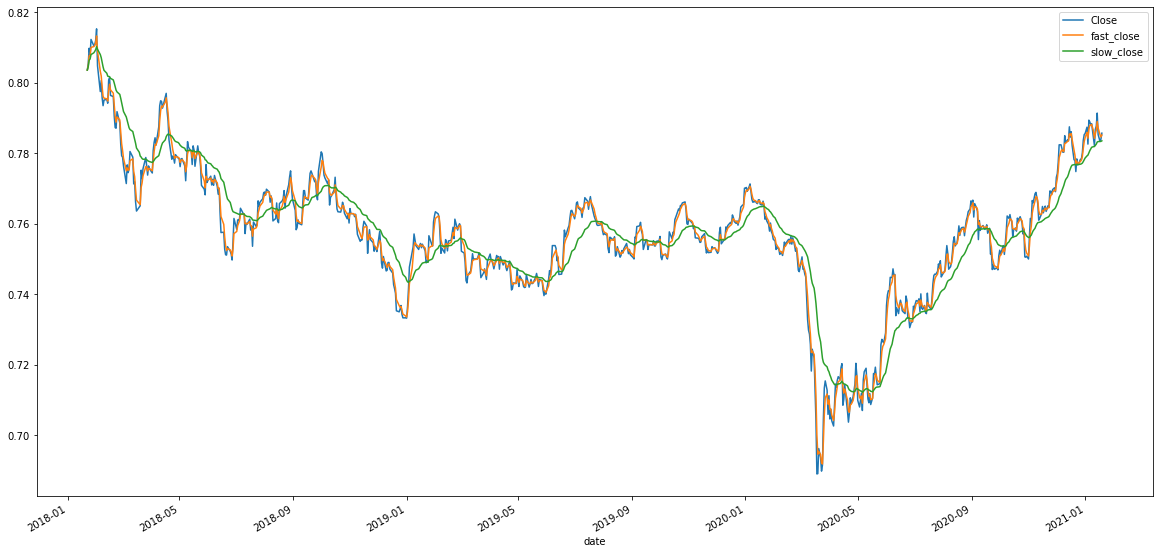

In [9]:
# Plot the EMA of CAD/USD closing prices
#!python -m pip install -U matplotlib

eod_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [10]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eod_df['fast_vol'] = eod_df['daily_return'].ewm(halflife=short_vol_window).std()
eod_df['slow_vol'] = eod_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
eod_df['vol_trend_long'] = np.where(eod_df['fast_vol'] < eod_df['slow_vol'], 1.0, 0.0)
eod_df['vol_trend_short'] = np.where(eod_df['fast_vol'] > eod_df['slow_vol'], -1.0, 0.0) 
eod_df['vol_trend_signal'] = eod_df['vol_trend_long'] + eod_df['vol_trend_short']

eod_df.head(20)

Close   Symbol  daily_return  fast_close  slow_close  \
date                                                                
2018-01-22  0.8036  CAD/USD           NaN    0.803600    0.803600   
2018-01-23  0.8054  CAD/USD      0.002240    0.804800    0.804531   
2018-01-24  0.8098  CAD/USD      0.005463    0.807657    0.806410   
2018-01-25  0.8076  CAD/USD     -0.002717    0.807627    0.806739   
2018-01-26  0.8123  CAD/USD      0.005820    0.810039    0.808011   
2018-01-29  0.8105  CAD/USD     -0.002216    0.810273    0.808501   
2018-01-30  0.8108  CAD/USD      0.000370    0.810539    0.808901   
2018-01-31  0.8120  CAD/USD      0.001480    0.811272    0.809389   
2018-02-01  0.8153  CAD/USD      0.004064    0.813290    0.810242   
2018-02-02  0.8048  CAD/USD     -0.012879    0.809041    0.809513   
2018-02-05  0.7975  CAD/USD     -0.009071    0.803268    0.808005   
2018-02-06  0.8006  CAD/USD      0.003887    0.801933    0.807127   
2018-02-07  0.7957  CAD/USD     -0.006120    0.798816    0.805838   
2018-02-08  0.7935  CAD/USD     -0.002765    0.796158    0.804508   
2018-02-09  0.7951  CAD/USD      0.002016    0.795629    0.803533   
2018-02-12  0.7953  CAD/USD      0.000252    0.795464    0.802711   
2018-02-13  0.7942  CAD/USD     -0.001383    0.794832    0.801887   
2018-02-14  0.8007  CAD/USD      0.008184    0.797766    0.801776   
2018-02-15  0.8014  CAD/USD      0.000874    0.799583    0.801741   
2018-02-16  0.7964  CAD/USD     -0.006239    0.797992    0.801264   

            crossover_long  crossover_short  crossover_signal  fast_vol  \
date                                                                      
2018-01-22             0.0              0.0               0.0       NaN   
2018-01-23             1.0              0.0               1.0       NaN   
2018-01-24             1.0              0.0               1.0  0.002279   
2018-01-25             1.0              0.0               1.0  0.004834   
2018-01-26             1.0              0.0               1.0  0.004699   
2018-01-29             1.0              0.0               1.0  0.004680   
2018-01-30             1.0              0.0               1.0  0.003255   
2018-01-31             1.0              0.0               1.0  0.002378   
2018-02-01             1.0              0.0               1.0  0.002543   
2018-02-02             0.0             -1.0              -1.0  0.009602   
2018-02-05             0.0             -1.0              -1.0  0.007186   
2018-02-06             0.0             -1.0              -1.0  0.008449   
2018-02-07             0.0             -1.0              -1.0  0.006578   
2018-02-08             0.0             -1.0              -1.0  0.004700   
2018-02-09             0.0             -1.0              -1.0  0.004660   
2018-02-12             0.0             -1.0              -1.0  0.003341   
2018-02-13             0.0             -1.0              -1.0  0.002471   
2018-02-14             0.0             -1.0              -1.0  0.005768   
2018-02-15             0.0             -1.0              -1.0  0.004429   
2018-02-16             0.0             -1.0              -1.0  0.006088   

            slow_vol  vol_trend_long  vol_trend_short  vol_trend_signal  
date                                                                     
2018-01-22       NaN             0.0              0.0               0.0  
2018-01-23       NaN             0.0              0.0               0.0  
2018-01-24  0.002279             0.0             -1.0              -1.0  
2018-01-25  0.004199             0.0             -1.0              -1.0  
2018-01-26  0.004029             0.0             -1.0              -1.0  
2018-01-29  0.004140             0.0             -1.0              -1.0  
2018-01-30  0.003675             1.0              0.0               1.0  
2018-01-31  0.003294             1.0              0.0               1.0  
2018-02-01  0.003172             1.0              0.0               1.0  
2018-02-02  0.006207         

### Plot Exponential Moving Average of Daily Return Volatility

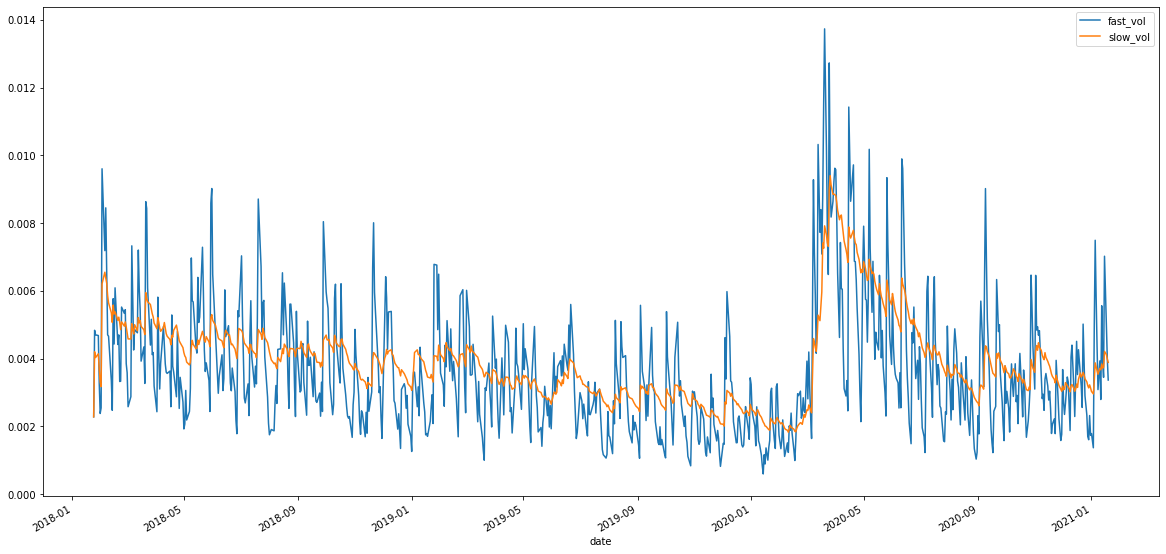

In [11]:
# Plot the EMA of CAD/USD daily return volatility
eod_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

### Construct Bollinger Band (Trading Signal, Feature Three)

In [12]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
eod_df['bollinger_mid_band'] = eod_df['Close'].rolling(window=bollinger_window).mean()
eod_df['bollinger_std'] = eod_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
eod_df['bollinger_upper_band']  = eod_df['bollinger_mid_band'] + (eod_df['bollinger_std'] * 1)
eod_df['bollinger_lower_band']  = eod_df['bollinger_mid_band'] - (eod_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
eod_df['bollinger_long'] = np.where(eod_df['Close'] < eod_df['bollinger_lower_band'], 1.0, 0.0)
eod_df['bollinger_short'] = np.where(eod_df['Close'] > eod_df['bollinger_upper_band'], -1.0, 0.0)
eod_df['bollinger_signal'] = eod_df['bollinger_long'] + eod_df['bollinger_short']

eod_df.head()

Close   Symbol  daily_return  fast_close  slow_close  \
date                                                                
2018-01-22  0.8036  CAD/USD           NaN    0.803600    0.803600   
2018-01-23  0.8054  CAD/USD      0.002240    0.804800    0.804531   
2018-01-24  0.8098  CAD/USD      0.005463    0.807657    0.806410   
2018-01-25  0.8076  CAD/USD     -0.002717    0.807627    0.806739   
2018-01-26  0.8123  CAD/USD      0.005820    0.810039    0.808011   

            crossover_long  crossover_short  crossover_signal  fast_vol  \
date                                                                      
2018-01-22             0.0              0.0               0.0       NaN   
2018-01-23             1.0              0.0               1.0       NaN   
2018-01-24             1.0              0.0               1.0  0.002279   
2018-01-25             1.0              0.0               1.0  0.004834   
2018-01-26             1.0              0.0               1.0  0.004699   

            slow_vol  vol_trend_long  vol_trend_short  vol_trend_signal  \
date                                                                      
2018-01-22       NaN             0.0              0.0               0.0   
2018-01-23       NaN             0.0              0.0               0.0   
2018-01-24  0.002279             0.0             -1.0              -1.0   
2018-01-25  0.004199             0.0             -1.0              -1.0   
2018-01-26  0.004029             0.0             -1.0              -1.0   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
date                                                                  
2018-01-22                 NaN            NaN                   NaN   
2018-01-23                 NaN            NaN                   NaN   
2018-01-24                 NaN            NaN                   NaN   
2018-01-25                 NaN            NaN                   NaN   
2018-01-26                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_short  \
date                                                                
2018-01-22                   NaN             0.0              0.0   
2018-01-23                   NaN             0.0              0.0   
2018-01-24                   NaN             0.0              0.0   
2018-01-25                   NaN             0.0              0.0   
2018-01-26                   NaN             0.0              0.0   

            bollinger_signal  
date                          
2018-01-22               0.0  
2018-01-23               0.0  
2018-01-24               0.0  
2018-01-25               0.0  
2018-01-26               0.0

### **Plot Bollinger Bands**

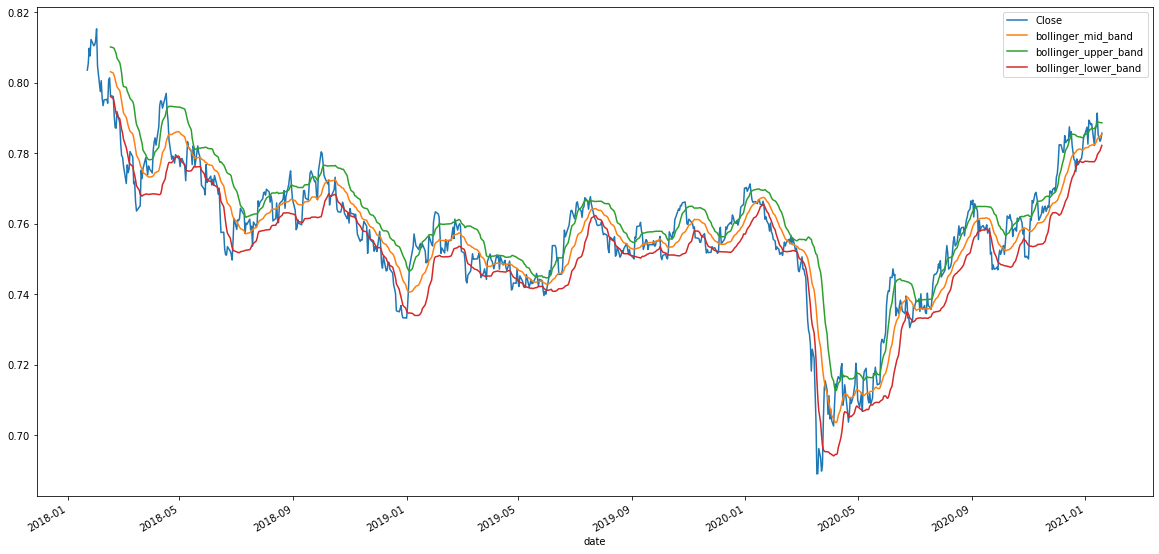

In [13]:
# Plot the Bollinger Bands for closing prices
eod_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `eod_df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [14]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In the forthcoming activities, we will predict closing prices using a `10` days windows of previous CAD/USD closing prices, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `10` and setting the features and target column numbers to `0` (this is the column with the CAD/USD closing prices).

In [15]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 3

feature_column = 0
target_column = 0
X, y = window_data(eod_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:15]} \n")
print (f"y sample values:\n{y[:15]}")

X sample values:
[[0.8036 0.8054 0.8098]
 [0.8054 0.8098 0.8076]
 [0.8098 0.8076 0.8123]
 [0.8076 0.8123 0.8105]
 [0.8123 0.8105 0.8108]
 [0.8105 0.8108 0.812 ]
 [0.8108 0.812  0.8153]
 [0.812  0.8153 0.8048]
 [0.8153 0.8048 0.7975]
 [0.8048 0.7975 0.8006]
 [0.7975 0.8006 0.7957]
 [0.8006 0.7957 0.7935]
 [0.7957 0.7935 0.7951]
 [0.7935 0.7951 0.7953]
 [0.7951 0.7953 0.7942]] 

y sample values:
[[0.8076]
 [0.8123]
 [0.8105]
 [0.8108]
 [0.812 ]
 [0.8153]
 [0.8048]
 [0.7975]
 [0.8006]
 [0.7957]
 [0.7935]
 [0.7951]
 [0.7953]
 [0.7942]
 [0.8007]]


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [16]:
# Drop NAs and replace positive/negative infinity values
eod_df.dropna(subset=['daily_return', 'crossover_signal', 'vol_trend_signal', 'bollinger_signal'], inplace=True)
eod_df = eod_df.replace([np.inf, -np.inf], np.nan)
eod_df.head()

Close   Symbol  daily_return  fast_close  slow_close  \
date                                                                
2018-01-23  0.8054  CAD/USD      0.002240    0.804800    0.804531   
2018-01-24  0.8098  CAD/USD      0.005463    0.807657    0.806410   
2018-01-25  0.8076  CAD/USD     -0.002717    0.807627    0.806739   
2018-01-26  0.8123  CAD/USD      0.005820    0.810039    0.808011   
2018-01-29  0.8105  CAD/USD     -0.002216    0.810273    0.808501   

            crossover_long  crossover_short  crossover_signal  fast_vol  \
date                                                                      
2018-01-23             1.0              0.0               1.0       NaN   
2018-01-24             1.0              0.0               1.0  0.002279   
2018-01-25             1.0              0.0               1.0  0.004834   
2018-01-26             1.0              0.0               1.0  0.004699   
2018-01-29             1.0              0.0               1.0  0.004680   

            slow_vol  vol_trend_long  vol_trend_short  vol_trend_signal  \
date                                                                      
2018-01-23       NaN             0.0              0.0               0.0   
2018-01-24  0.002279             0.0             -1.0              -1.0   
2018-01-25  0.004199             0.0             -1.0              -1.0   
2018-01-26  0.004029             0.0             -1.0              -1.0   
2018-01-29  0.004140             0.0             -1.0              -1.0   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
date                                                                  
2018-01-23                 NaN            NaN                   NaN   
2018-01-24                 NaN            NaN                   NaN   
2018-01-25                 NaN            NaN                   NaN   
2018-01-26                 NaN            NaN                   NaN   
2018-01-29                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_short  \
date                                                                
2018-01-23                   NaN             0.0              0.0   
2018-01-24                   NaN             0.0              0.0   
2018-01-25                   NaN             0.0              0.0   
2018-01-26                   NaN             0.0              0.0   
2018-01-29                   NaN             0.0              0.0   

            bollinger_signal  
date                          
2018-01-23               0.0  
2018-01-24               0.0  
2018-01-25               0.0  
2018-01-26               0.0  
2018-01-29               0.0

### Construct the Dependent Variable

In [17]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
eod_df['Positive Return'] = np.where(eod_df['daily_return'] > 0, 1.0, 0.0)
eod_df

Close   Symbol  daily_return  fast_close  slow_close  \
date                                                                
2018-01-23  0.8054  CAD/USD      0.002240    0.804800    0.804531   
2018-01-24  0.8098  CAD/USD      0.005463    0.807657    0.806410   
2018-01-25  0.8076  CAD/USD     -0.002717    0.807627    0.806739   
2018-01-26  0.8123  CAD/USD      0.005820    0.810039    0.808011   
2018-01-29  0.8105  CAD/USD     -0.002216    0.810273    0.808501   
...            ...      ...           ...         ...         ...   
2021-01-14  0.7914  CAD/USD      0.004697    0.789006    0.783184   
2021-01-15  0.7853  CAD/USD     -0.007708    0.787153    0.783325   
2021-01-17  0.7834  CAD/USD     -0.002419    0.785276    0.783330   
2021-01-18  0.7840  CAD/USD      0.000766    0.784638    0.783375   
2021-01-19  0.7857  CAD/USD      0.002168    0.785169    0.783531   

            crossover_long  crossover_short  crossover_signal  fast_vol  \
date                                                                      
2018-01-23             1.0              0.0               1.0       NaN   
2018-01-24             1.0              0.0               1.0  0.002279   
2018-01-25             1.0              0.0               1.0  0.004834   
2018-01-26             1.0              0.0               1.0  0.004699   
2018-01-29             1.0              0.0               1.0  0.004680   
...                    ...              ...               ...       ...   
2021-01-14             1.0              0.0               1.0  0.003445   
2021-01-15             1.0              0.0               1.0  0.007020   
2021-01-17             1.0              0.0               1.0  0.004964   
2021-01-18             1.0              0.0               1.0  0.004003   
2021-01-19             1.0              0.0               1.0  0.003366   

            slow_vol  ...  vol_trend_short  vol_trend_signal  \
date                  ...                                      
2018-01-23       NaN  ...              0.0               0.0   
2018-01-24  0.002279  ...             -1.0              -1.0   
2018-01-25  0.004199  ...             -1.0              -1.0   
2018-01-26  0.004029  ...             -1.0              -1.0   
2018-01-29  0.004140  ...             -1.0              -1.0   
...              ...  ...              ...               ...   
2021-01-14  0.003745  ...              0.0               1.0   
2021-01-15  0.004211  ...             -1.0              -1.0   
2021-01-17  0.004121  ...             -1.0              -1.0   
2021-01-18  0.003985  ...             -1.0              -1.0   
2021-01-19  0.003886  ...              0.0               1.0   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
date                                                                  
2018-01-23                 NaN            NaN                   NaN   
2018-01-24                 NaN            NaN                   NaN   
2018-01-25                 NaN            NaN                   NaN   
2018-01-26                 NaN            NaN                   NaN   
2018-01-29                 NaN            NaN                   NaN   
...                        ...            ...                   ...   
2021-01-14            0.784040       0.004586              0.788626   
2021-01-15            0.784385       0.004395              0.788780   
2021-01-17            0.784720       0.004017              0.788737   
2021-01-18            0.785070       0.003592              0.788662   
2021-01-19            0.785440       0.003219              0.788659   

            bollinger_lower_band  bollinger_long  bollinger_short  \
date                                                                
2018-01-23                   NaN             0.0              0.0   
2018-01-24                   NaN             0.0              0.0   
2018-01-25                   NaN             0.0              0.0   
2018-01-26                   NaN     

### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [18]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that due to the CAD/USD data arange, we will skip the scaling both features and target sets.

In [19]:
# Use the MinMaxScaler to scale data between 0 and 1.
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaler.fit(X)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
#scaler.fit(y)
#y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [20]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.8036]
  [0.8054]
  [0.8098]]

 [[0.8054]
  [0.8098]
  [0.8076]]

 [[0.8098]
  [0.8076]
  [0.8123]]

 [[0.8076]
  [0.8123]
  [0.8105]]

 [[0.8123]
  [0.8105]
  [0.8108]]] 

X_test sample values:
[[[0.7128]
  [0.7059]
  [0.7112]]

 [[0.7059]
  [0.7112]
  [0.7046]]

 [[0.7112]
  [0.7046]
  [0.7074]]

 [[0.7046]
  [0.7074]
  [0.7041]]

 [[0.7074]
  [0.7041]
  [0.7026]]]


## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [21]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [22]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [23]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [24]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 10)             480       
_________________________________________________________________
dropout (Dropout)            (None, 3, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 10)             840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [25]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
583/583 [==============================] - 6s 5ms/step - loss: 0.1627
Epoch 2/10
583/583 [==============================] - 3s 5ms/step - loss: 0.0140
Epoch 3/10
583/583 [==============================] - 4s 6ms/step - loss: 0.0103
Epoch 4/10
583/583 [==============================] - 3s 5ms/step - loss: 0.0074
Epoch 5/10
583/583 [==============================] - 3s 5ms/step - loss: 0.0057
Epoch 6/10
583/583 [==============================] - 3s 4ms/step - loss: 0.0048
Epoch 7/10
583/583 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 8/10
583/583 [==============================] - 3s 5ms/step - loss: 0.0036
Epoch 9/10
583/583 [==============================] - 4s 6ms/step - loss: 0.0026
Epoch 10/10
583/583 [==============================] - 4s 6ms/step - loss: 0.0021


## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [26]:
# Evaluate the model
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 2ms/step - loss: 0.0021 


0.00208113226108253

### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [27]:
# Make some predictions
predicted = model.predict(X_test)

Since we did not scale the original values using the `MinMaxScaler`, we don't need to recover the original prices to better understand the predictions.

We will skip using the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [28]:
# Recover the original prices instead of the scaled version
#predicted_prices = scaler.inverse_transform(predicted)
predicted_prices = predicted

#real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
real_prices = y_test

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [29]:
# Create a DataFrame of Real and Predicted values
exchange_rate = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = eod_df.index[-len(real_prices): ])

exchange_rate.head()

Real  Predicted
date                         
2020-04-01  0.7046   0.710000
2020-04-02  0.7074   0.709988
2020-04-03  0.7041   0.709993
2020-04-05  0.7026   0.709979
2020-04-06  0.7087   0.709981

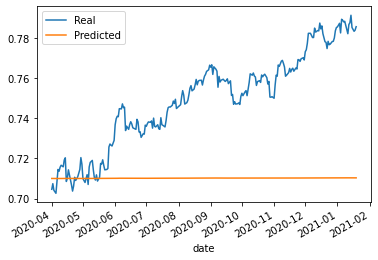

In [30]:
# Plot the real vs predicted prices as a line chart
exchange_rate.plot()

In [31]:
n_kw_list = ["castor","coconut", "cotton", "groundnut", "lin", "palm", "rape", "soy","sun", "veg", "vegetable" ]
kw_list = ["crude","oil"]